<a href="https://colab.research.google.com/github/ankita94sahoo/age_of_information/blob/master/Bitcoin_Prediction_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Time Series Forecasting
Bitcoin is the longest running and most well known cryptocurrency, first released as open source in 2009 by the anonymous Satoshi Nakamoto. Bitcoin serves as a decentralized medium of digital exchange, with transactions verified and recorded in a public distributed ledger (the blockchain) without the need for a trusted record keeping authority or central intermediary. Transaction blocks contain a SHA-256 cryptographic hash of previous transaction blocks, and are thus "chained" together, serving as an immutable record of all transactions that have ever occurred. As with any currency/commodity on the market, bitcoin trading and financial instruments soon followed public adoption of bitcoin and continue to grow. If you don't know what Bitcoin is , then get some knowledge about Bitcoin here .


In [ ]:
# pip install plotly

In [ ]:
import numpy as np #linear algebra
import pandas as pd #data processing, CSV files I/O
import matplotlib.pyplot as plt

from plotly import tools
import plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc

import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bitcoin = pd.read_csv('/content/drive/MyDrive/Semester Project/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv.zip',
                   index_col=[0], parse_dates=[0]) # We set the index column and know it has dates

In [ ]:
bitcoin.head(5)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1417412040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417412100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417412160,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1417412220,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Data Exploration**

In this section we just explore the Data i.e the Historic Bitcoin Prices and try to find some insights. We will be using the Coinbase dataset as it is one of the mostly used Bitcoin Exchange/Wallet in the world.

In [ ]:
import datetime, pytz
#define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))


data = pd.read_csv('/content/drive/MyDrive/Semester Project/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv.zip',
                   index_col=[0], parse_dates=[0])

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2016354 entries, 1417411980 to 1541894400
Data columns (total 7 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Open               float64
 1   High               float64
 2   Low                float64
 3   Close              float64
 4   Volume_(BTC)       float64
 5   Volume_(Currency)  float64
 6   Weighted_Price     float64
dtypes: float64(7)
memory usage: 123.1 MB


Little preprocessing required, replacing the NaN values with zeroes and previous data.

In [ ]:
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
data['Volume_(BTC)'].fillna(value=0, inplace=True)
data['Volume_(Currency)'].fillna(value=0, inplace=True)
data['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
data['Open'].fillna(method='ffill', inplace=True)
data['High'].fillna(method='ffill', inplace=True)
data['Low'].fillna(method='ffill', inplace=True)
data['Close'].fillna(method='ffill', inplace=True)

data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1417412040,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412100,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412160,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412220,300.0,300.0,300.0,300.0,0.00,0.0,0.0


Creating Weekly Rows for the Data Visualization

In [ ]:
# create valid date range
start = datetime.datetime(2015, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2018, 11, 11, 0, 0, 0, 0, pytz.UTC)

In [ ]:
data.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1417412040,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412100,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412160,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412220,300.0,300.0,300.0,300.0,0.00,0.0,0.0


In [ ]:
# data['Timestamp']=data.index
data= data.reset_index()

In [ ]:
data.head(5)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,1417412040,300.0,300.0,300.0,300.0,0.00,0.0,0.0
2,1417412100,300.0,300.0,300.0,300.0,0.00,0.0,0.0
3,1417412160,300.0,300.0,300.0,300.0,0.00,0.0,0.0
4,1417412220,300.0,300.0,300.0,300.0,0.00,0.0,0.0


In [ ]:
data['Timestamp'] = data['Timestamp'].apply(dateparse)
# data['Timestamp'] = dateparse(data['Timestamp'])

In [ ]:
# find rows between start and end time and find the first row (00:00 monday morning)
weekly_rows = data[(data['Timestamp'] >= start) & (data['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='W-MON')]).first().reset_index()
# weekly_rows= weekly_rows.drop(['Timestamp_final'],axis=1)
weekly_rows.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2015-01-12 00:00:00+00:00,360.00,360.00,360.00,360.00,0.0100,3.600000,360.00
1,2015-01-19 00:00:00+00:00,260.00,260.00,260.00,260.00,1.0000,260.000000,260.00
2,2015-01-26 00:00:00+00:00,225.51,225.51,225.51,225.51,0.0000,0.000000,0.00
3,2015-02-02 00:00:00+00:00,274.73,274.73,274.73,274.73,0.2428,66.704444,274.73
4,2015-02-09 00:00:00+00:00,237.83,237.83,237.83,237.83,0.0000,0.000000,0.00


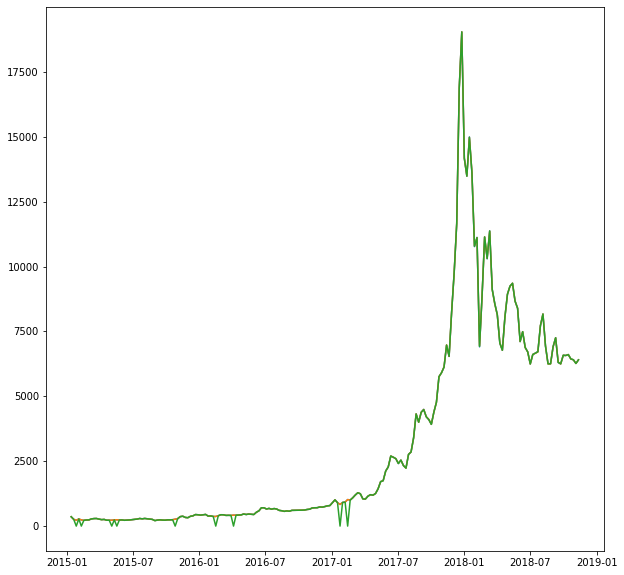

In [ ]:
#Historical Bitcoin Prices (2015-2018)
fig,(ax1) = plt.subplots(1,sharex=True, figsize=(10,10))
x = weekly_rows['Timestamp']
y = weekly_rows['Open']

x1 = weekly_rows['Timestamp']
y1 = weekly_rows['Close']

x2 = weekly_rows['Timestamp']
y2 = weekly_rows['Weighted_Price']

ax1.plot(x,y)
ax1.plot(x1,y1)
ax1.plot(x2,y2)

Lets visualize Historical Bitcoin Market Volume (2015-2018)

In [ ]:
# #Historical Bitcoin Market Volume (2015-2018)
# fig,(ax2) = plt.subplots(1,sharex=True, figsize=(10,10))
# x = weekly_rows['Timestamp'],
# y = weekly_rows['Volume_(Currency)']

# ax2.plot(x,y)

In [ ]:
# trace1 = go.Scatter(
#     x = weekly_rows['Timestamp'],
#     y = weekly_rows['Volume_(Currency)'].astype(float),
#     mode = 'lines',
#     name = 'Bitcoin Price (Open)'
# )

# layout = dict(
#     title='Historical Bitcoin Volume (USD) (2015-2018) with the slider',
#     xaxis=dict(
#         rangeselector=dict(
#             buttons=list([
#                 dict(count=1,
#                      label='1m',
#                      step='month',
#                      stepmode='backward'),
#                 dict(count=6,
#                      label='6m',
#                      step='month',
#                      stepmode='backward'),
#                 dict(count=12,
#                      label='1y',
#                      step='month',
#                      stepmode='backward'),
#                 dict(count=36,
#                      label='3y',
#                      step='month',
#                      stepmode='backward'),
#                 dict(step='all')
#             ])
#         ),
#         rangeslider=dict(
#             visible = True
#         ),
#         type='date'
#     )
# )

# data = [trace1]
# fig = dict(data=data, layout=layout)
# iplot(fig, filename = "Time Series with Rangeslider")

History of Bitcoin Prices

1. 18 August 2008, the domain name bitcoin.org was registered.
2. November 6th 2010, Bitcoin share capital reaches 1 million USD. Its exchange rate on MtGox reaches USD 0.50 per BTC.
3. June 2nd 2011, USD to BTC rate is 10 USD to the coin. For 6 days, the Bitcoin value is fixed at 31.91 USD on MtGox.
4. February 28th 2013, Bitcoin exchange rate surpasses 31.91 USD for the first time for the last 601 days.
5. April 1st,2013 Exchange rate of Bitcoin reaches 100 USD to 1 BTC.
January,2015 Coinbase raised 75 million USD as part of a Series C funding round, smashing the previous record for a bitcoin company.
6. February ,2015 Bitcoin price reached USD 262.
7. January 2017,After the rally for most of the second half of 2016, bitcoin broke the USD 1,000 mark for the first time in 3 years.
8. June 12th 2017, Bitcoin exchange rate exceeds USD 3000 to the BTC.
9. November 29th 2017, Bitcoin price exceeds USD 10,000.
10. December 18th 2017, Bitcoin reaches a record high, but does not reach USD 20,000.
11. December 28th 2017, The price of bitcoins fell after South Korea announced additional measures to regulate bitcoin trading, including the potential closure of exchanges, among the volatile movements in the world's third largest cryptocurrency market.
12. October 31st 2018, USD 6,300, on the 10 year anniversary of Bitcoin, price holds steady above USD 6,000 during a period of historically low volatility.





**Time Series Forecasting**

Here in this kernel, we attempt to perform Time Series Analysis on the Historic Bitcoin Price data. We can easily see from the Data Exploration section, that the Bitcoin prices were quite volatile and inconsistent over the years. Its very hard to perform Time series analysis on such volatile data. But here we try to explore the different Time series forecasting models. All the models used in this Kernel are very basic, there is scope of more complex and better performing models.

1. Time Series forecasting with LSTM
2. Time Series forecasting with XGBoost
3. Time Series forecasting with Facebook Prophet
4. Time Series forecasting with ARIMA


**Predicting using LSTM**

In the first section, we use LSTM (Long short-term memory ). LSTM units are units of a recurrent neural network (RNN). An RNN composed of LSTM units is often called an LSTM network (or just LSTM). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell. Read more about LSTMs here.

Though LSTM is not ideal for forecasting turbulent market like Bitcoin but we still take a chance here.

In [ ]:
#load the dataset 
data_lstm = pd.read_csv('/content/drive/MyDrive/Semester Project/coinbaseUSD_1-min_data_2014-12-01_to_2018-11-11.csv.zip',
                   index_col=[0], parse_dates=[0])
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill na's with zeroes for relevant fields...
data_lstm['Volume_(BTC)'].fillna(value=0, inplace=True)
data_lstm['Volume_(Currency)'].fillna(value=0, inplace=True)
data_lstm['Weighted_Price'].fillna(value=0, inplace=True)

# next we need to fix the OHLC (open high low close) data which is a continuous timeseries so
# lets fill forwards those values...
data_lstm['Open'].fillna(method='ffill', inplace=True)
data_lstm['High'].fillna(method='ffill', inplace=True)
data_lstm['Low'].fillna(method='ffill', inplace=True)
data_lstm['Close'].fillna(method='ffill', inplace=True)

data_lstm.head()

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
1417411980,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1417412040,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412100,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412160,300.0,300.0,300.0,300.0,0.00,0.0,0.0
1417412220,300.0,300.0,300.0,300.0,0.00,0.0,0.0


In [ ]:
data_lstm= data_lstm.reset_index()

In [ ]:
data_lstm['Timestamp'] = data_lstm['Timestamp'].apply(dateparse)
data_lstm.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,2014-12-01 05:33:00+00:00,300.0,300.0,300.0,300.0,0.01,3.0,300.0
1,2014-12-01 05:34:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
2,2014-12-01 05:35:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
3,2014-12-01 05:36:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0
4,2014-12-01 05:37:00+00:00,300.0,300.0,300.0,300.0,0.00,0.0,0.0


In [ ]:
data_lstm.index

RangeIndex(start=0, stop=2016354, step=1)

In [ ]:
data_lstm['Timestamp'] = data_lstm['Timestamp'].dt.tz_localize(None)
data_lstm = data_lstm.groupby([pd.Grouper(key='Timestamp', freq='H')]).first().reset_index()
data_lstm = data_lstm.set_index('Timestamp')
data_lstm = data_lstm[['Weighted_Price']]
data_lstm['Weighted_Price'].fillna(method='ffill', inplace=True)

In [ ]:
# split data
split_date = '25-06-2018'
# from datetime import datetime
# split_date_obj = datetime. strptime(split_date, "%d-%m-%Y %H:%M:%S")
data_train = data_lstm.loc[data_lstm.index <= split_date].copy()
data_test = data_lstm.loc[data_lstm.index > split_date].copy()

In [ ]:
#Checking the length of dataset
print('DataSet length =',len(data_lstm))
print('Train dataset length =',len(data_train))
print('Test dataset length =',len(data_test))

DataSet length = 34580
Train dataset length = 31244
Test dataset length = 3336


In [ ]:
data_train.head()

,Weighted_Price
Timestamp,
2014-12-01 05:00:00,300.0
2014-12-01 06:00:00,0.0
2014-12-01 07:00:00,0.0
2014-12-01 08:00:00,0.0
2014-12-01 09:00:00,0.0


In [ ]:
# Data preprocess
training_set = data_train.values
training_set = np.reshape(training_set, (len(training_set), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = np.reshape(X_train, (len(X_train), 1, 1))

In [ ]:
data_lstm.dtypes

Weighted_Price    float64
dtype: object

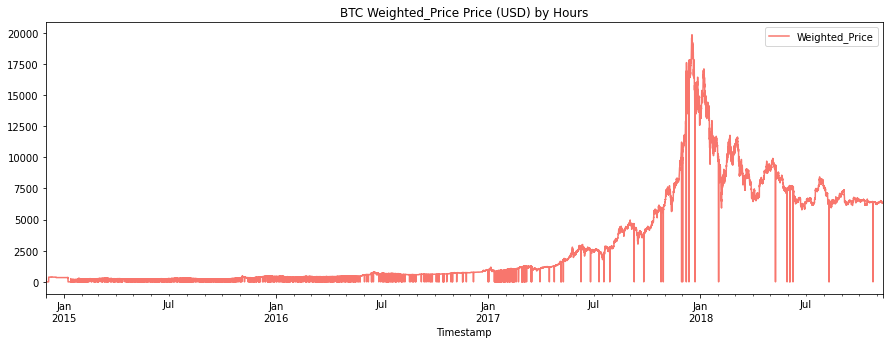

In [ ]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]
_ = data_lstm.plot(style='', figsize=(15,5), color=color_pal[0], title='BTC Weighted_Price Price (USD) by Hours')

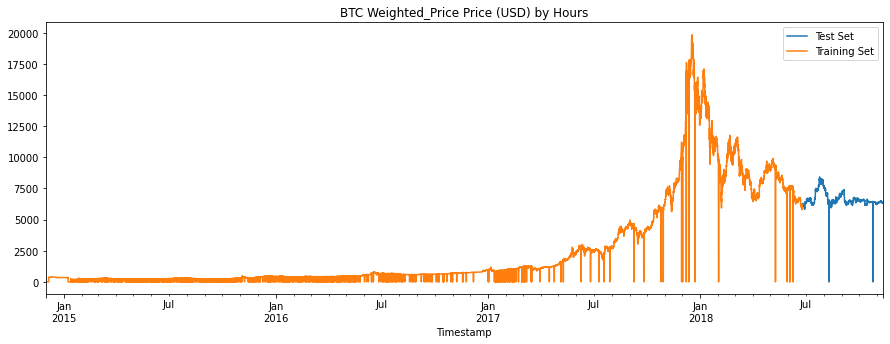

In [ ]:
_ = data_test\
    .rename(columns={'Weighted_Price': 'Test Set'}) \
    .join(data_train.rename(columns={'Weighted_Price': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Weighted_Price Price (USD) by Hours', style='')

Vanilla LSTM here for forecasting. The model is trained on pre 25-Jun-2018 data.

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
625/625 - 3s - loss: 0.0373 - 3s/epoch - 6ms/step
Epoch 2/100
625/625 - 2s - loss: 0.0124 - 2s/epoch - 3ms/step
Epoch 3/100
625/625 - 2s - loss: 0.0069 - 2s/epoch - 3ms/step
Epoch 4/100
625/625 - 2s - loss: 0.0048 - 2s/epoch - 3ms/step
Epoch 5/100
625/625 - 2s - loss: 0.0038 - 2s/epoch - 3ms/step
Epoch 6/100
625/625 - 2s - loss: 0.0032 - 2s/epoch - 3ms/step
Epoch 7/100
625/625 - 2s - loss: 0.0026 - 2s/epoch - 3ms/step
Epoch 8/100
625/625 - 2s - loss: 0.0023 - 2s/epoch - 3ms/step
Epoch 9/100
625/625 - 2s - loss: 0.0020 - 2s/epoch - 3ms/step
Epoch 10/100
625/625 - 2s - loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 11/100
625/625 - 2s - loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 12/100
625/625 - 2s - loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 13/100
625/625 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 14/100
625/625 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 15/100
625/625 - 2s - loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 16/100
625/625 - 2s - loss: 0.0011 - 2s/epoch - 3ms/step
E

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Making the predictions
test_set = data_test.values
inputs = np.reshape(test_set, (len(test_set), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [ ]:
data_test['Weighted_Price_Prediction'] = predicted_BTC_price
data_all = pd.concat([data_test, data_train], sort=False)

In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

9823.688929645956

In [ ]:
mean_absolute_error(y_true=data_test['Weighted_Price'],
                   y_pred=data_test['Weighted_Price_Prediction'])

98.46766705935343

Putting Static Delay to dataset

In [ ]:
data_lstm_delay=data_lstm.copy()

In [ ]:
data_lstm_delay.index

DatetimeIndex(['2014-12-01 05:00:00', '2014-12-01 06:00:00',
               '2014-12-01 07:00:00', '2014-12-01 08:00:00',
               '2014-12-01 09:00:00', '2014-12-01 10:00:00',
               '2014-12-01 11:00:00', '2014-12-01 12:00:00',
               '2014-12-01 13:00:00', '2014-12-01 14:00:00',
               ...
               '2018-11-10 15:00:00', '2018-11-10 16:00:00',
               '2018-11-10 17:00:00', '2018-11-10 18:00:00',
               '2018-11-10 19:00:00', '2018-11-10 20:00:00',
               '2018-11-10 21:00:00', '2018-11-10 22:00:00',
               '2018-11-10 23:00:00', '2018-11-11 00:00:00'],
              dtype='datetime64[ns]', name='Timestamp', length=34580, freq=None)

In [ ]:
data_lstm_delay['Delayed_Time']= data_lstm_delay.index.copy()

In [ ]:
data_lstm_delay.head()

,Weighted_Price,Delayed_Time
Timestamp,,
2014-12-01 05:00:00,300.0,2014-12-01 05:00:00
2014-12-01 06:00:00,0.0,2014-12-01 06:00:00
2014-12-01 07:00:00,0.0,2014-12-01 07:00:00
2014-12-01 08:00:00,0.0,2014-12-01 08:00:00
2014-12-01 09:00:00,0.0,2014-12-01 09:00:00


In [ ]:
data_lstm_delay.columns

Index(['Weighted_Price', 'Delayed_Time'], dtype='object')

In [ ]:
# data_lstm['Delayed_Time'][1] = data_lstm['Delayed_Time'][1] + dt.rin

rand_int = np.random.randint(1,34,size=34580) #random delay 
# static_int = 30 #to calculate static delay
# rand_int = np.random.uniform(1,10,size=34580) #uniform delay
data_lstm_delay['rand_int'] = rand_int
#pjme['static_int'] = static_int
data_lstm_delay.head(5)

,Weighted_Price,Delayed_Time,rand_int
Timestamp,,,
2014-12-01 05:00:00,300.0,2014-12-01 05:00:00,11
2014-12-01 06:00:00,0.0,2014-12-01 06:00:00,25
2014-12-01 07:00:00,0.0,2014-12-01 07:00:00,10
2014-12-01 08:00:00,0.0,2014-12-01 08:00:00,2
2014-12-01 09:00:00,0.0,2014-12-01 09:00:00,4


In [ ]:
# data_lstm['Delayed_Time'] = data_lstm.Delayed_Time + data_lstm.rand_int.astype('timedelta64[h]') #to convert delay to minutes
# data_lstm['Delayed_Time'] = data_lstm.Delayed_Time + data_lstm.rand_int.astype('timedelta64[m]') #to convert delay to minutes
data_lstm_delay['Delayed_Time'] = data_lstm_delay.Delayed_Time + data_lstm_delay.rand_int.astype('timedelta64[s]') #to convert delay to seconds
data_lstm_delay.head(5)

,Weighted_Price,Delayed_Time,rand_int
Timestamp,,,
2014-12-01 05:00:00,300.0,2014-12-01 05:00:11,11
2014-12-01 06:00:00,0.0,2014-12-01 06:00:25,25
2014-12-01 07:00:00,0.0,2014-12-01 07:00:10,10
2014-12-01 08:00:00,0.0,2014-12-01 08:00:02,2
2014-12-01 09:00:00,0.0,2014-12-01 09:00:04,4


In [ ]:
data_lstm_delay.set_index('Delayed_Time')

,Weighted_Price,rand_int
Delayed_Time,,
2014-12-01 05:00:11,300.000000,11
2014-12-01 06:00:25,0.000000,25
2014-12-01 07:00:10,0.000000,10
2014-12-01 08:00:02,0.000000,2
2014-12-01 09:00:04,0.000000,4
...,...,...
2018-11-10 20:00:08,6358.393352,8
2018-11-10 21:00:05,6364.992297,5
2018-11-10 22:00:29,6361.263244,29


In [ ]:
data_lstm_delayed = data_lstm_delay.set_index('Delayed_Time')

In [ ]:
data_lstm_delayed.head()

,Weighted_Price,rand_int
Delayed_Time,,
2014-12-01 05:00:11,300.0,11
2014-12-01 06:00:25,0.0,25
2014-12-01 07:00:10,0.0,10
2014-12-01 08:00:02,0.0,2
2014-12-01 09:00:04,0.0,4


In [ ]:
data_lstm_delayed = data_lstm_delayed.drop(['rand_int'],axis=1)

In [ ]:
data_lstm_delayed.head()

,Weighted_Price
Delayed_Time,
2014-12-01 05:00:11,300.0
2014-12-01 06:00:25,0.0
2014-12-01 07:00:10,0.0
2014-12-01 08:00:02,0.0
2014-12-01 09:00:04,0.0


In [ ]:
#export to csv file
data_lstm_delayed.to_csv(r'/content/drive/MyDrive/Semester Project/data_lstm_delayed.csv')

In [ ]:
#Splitting the delayed datset
# split data
split_date = '25-06-2018'
# from datetime import datetime
# split_date_obj = datetime. strptime(split_date, "%d-%m-%Y %H:%M:%S")
data_train_delayed = data_lstm_delayed.loc[data_lstm_delayed.index <= split_date].copy()
data_test_delayed = data_lstm_delayed.loc[data_lstm_delayed.index > split_date].copy()

In [ ]:
#Checking the length of dataset
print('DataSet length =',len(data_lstm_delayed))
print('Train dataset length =',len(data_train_delayed))
print('Test dataset length =',len(data_test_delayed))

DataSet length = 34580
Train dataset length = 31243
Test dataset length = 3337


In [ ]:
# Data preprocess
training_set_delayed = data_train_delayed.values
training_set_delayed = np.reshape(training_set_delayed, (len(training_set_delayed), 1))
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
training_set_delayed = sc.fit_transform(training_set_delayed)
X_train_delayed = training_set_delayed[0:len(training_set_delayed)-1]
y_train_delayed = training_set_delayed[1:len(training_set_delayed)]
X_train_delayed = np.reshape(X_train_delayed, (len(X_train_delayed), 1, 1))

Train on Delayed and test on delayed

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_delayed, y_train_delayed, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
625/625 - 4s - loss: 0.0570 - 4s/epoch - 6ms/step
Epoch 2/100
625/625 - 2s - loss: 0.0205 - 2s/epoch - 3ms/step
Epoch 3/100
625/625 - 2s - loss: 0.0104 - 2s/epoch - 3ms/step
Epoch 4/100
625/625 - 2s - loss: 0.0062 - 2s/epoch - 3ms/step
Epoch 5/100
625/625 - 2s - loss: 0.0045 - 2s/epoch - 3ms/step
Epoch 6/100
625/625 - 2s - loss: 0.0035 - 2s/epoch - 3ms/step
Epoch 7/100
625/625 - 2s - loss: 0.0028 - 2s/epoch - 3ms/step
Epoch 8/100
625/625 - 2s - loss: 0.0024 - 2s/epoch - 3ms/step
Epoch 9/100
625/625 - 2s - loss: 0.0021 - 2s/epoch - 3ms/step
Epoch 10/100
625/625 - 2s - loss: 0.0019 - 2s/epoch - 3ms/step
Epoch 11/100
625/625 - 2s - loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 12/100
625/625 - 2s - loss: 0.0016 - 2s/epoch - 3ms/step
Epoch 13/100
625/625 - 2s - loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 14/100
625/625 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 15/100
625/625 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 16/100
625/625 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
E

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_9 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Making the predictions
test_set_delayed = data_test_delayed.values
inputs = np.reshape(test_set_delayed, (len(test_set_delayed), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [ ]:
data_test_delayed['Weighted_Price_Prediction'] = predicted_BTC_price
data_all_delayed = pd.concat([data_test, data_train], sort=False)

In [ ]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test_delayed['Weighted_Price'],
                   y_pred=data_test_delayed['Weighted_Price_Prediction'])

37217.28543011411

In [ ]:
mean_absolute_error(y_true=data_test_delayed['Weighted_Price'],
                   y_pred=data_test_delayed['Weighted_Price_Prediction'])

192.5591801772977

Train on Fresh and Test on delayed

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
625/625 - 3s - loss: 0.0599 - 3s/epoch - 5ms/step
Epoch 2/100
625/625 - 2s - loss: 0.0214 - 2s/epoch - 3ms/step
Epoch 3/100
625/625 - 2s - loss: 0.0113 - 2s/epoch - 3ms/step
Epoch 4/100
625/625 - 2s - loss: 0.0068 - 2s/epoch - 3ms/step
Epoch 5/100
625/625 - 2s - loss: 0.0047 - 2s/epoch - 3ms/step
Epoch 6/100
625/625 - 2s - loss: 0.0037 - 2s/epoch - 3ms/step
Epoch 7/100
625/625 - 2s - loss: 0.0030 - 2s/epoch - 3ms/step
Epoch 8/100
625/625 - 2s - loss: 0.0026 - 2s/epoch - 3ms/step
Epoch 9/100
625/625 - 2s - loss: 0.0022 - 2s/epoch - 3ms/step
Epoch 10/100
625/625 - 2s - loss: 0.0020 - 2s/epoch - 3ms/step
Epoch 11/100
625/625 - 2s - loss: 0.0018 - 2s/epoch - 3ms/step
Epoch 12/100
625/625 - 2s - loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 13/100
625/625 - 2s - loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 14/100
625/625 - 2s - loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 15/100
625/625 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 16/100
625/625 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
E

In [ ]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 128)               66560     
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________


In [ ]:
data_test_delayed = data_lstm_delayed.loc[data_lstm_delayed.index > split_date].copy()
test_set_delayed_1 = data_test_delayed.values

In [ ]:
# Making the predictions
test_set_delayed_1 = data_test_delayed.values
inputs = np.reshape(test_set_delayed_1, (len(test_set_delayed_1), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [ ]:
data_test_delayed['Weighted_Price_Prediction'] = predicted_BTC_price

In [ ]:
#calculate MSE and MAE of test 
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test_delayed['Weighted_Price'],
                   y_pred=data_test_delayed['Weighted_Price_Prediction'])

49396.61572866976

In [ ]:
mean_absolute_error(y_true=data_test_delayed['Weighted_Price'],
                   y_pred=data_test_delayed['Weighted_Price_Prediction'])

221.2150252995393

Train on delayed and Test on Fresh

In [ ]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train_delayed, y_train_delayed, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
625/625 - 3s - loss: 0.0462 - 3s/epoch - 5ms/step
Epoch 2/100
625/625 - 2s - loss: 0.0160 - 2s/epoch - 3ms/step
Epoch 3/100
625/625 - 2s - loss: 0.0082 - 2s/epoch - 3ms/step
Epoch 4/100
625/625 - 2s - loss: 0.0052 - 2s/epoch - 3ms/step
Epoch 5/100
625/625 - 2s - loss: 0.0039 - 2s/epoch - 3ms/step
Epoch 6/100
625/625 - 2s - loss: 0.0032 - 2s/epoch - 3ms/step
Epoch 7/100
625/625 - 2s - loss: 0.0027 - 2s/epoch - 3ms/step
Epoch 8/100
625/625 - 2s - loss: 0.0023 - 2s/epoch - 3ms/step
Epoch 9/100
625/625 - 2s - loss: 0.0020 - 2s/epoch - 3ms/step
Epoch 10/100
625/625 - 2s - loss: 0.0019 - 2s/epoch - 3ms/step
Epoch 11/100
625/625 - 2s - loss: 0.0017 - 2s/epoch - 3ms/step
Epoch 12/100
625/625 - 2s - loss: 0.0015 - 2s/epoch - 3ms/step
Epoch 13/100
625/625 - 2s - loss: 0.0014 - 2s/epoch - 3ms/step
Epoch 14/100
625/625 - 2s - loss: 0.0013 - 2s/epoch - 3ms/step
Epoch 15/100
625/625 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
Epoch 16/100
625/625 - 2s - loss: 0.0012 - 2s/epoch - 3ms/step
E

In [ ]:
data_test_1 = data_lstm.loc[data_lstm.index > split_date].copy()

In [ ]:
data_lstm.head()

,Weighted_Price
Timestamp,
2014-12-01 05:00:00,300.0
2014-12-01 06:00:00,0.0
2014-12-01 07:00:00,0.0
2014-12-01 08:00:00,0.0
2014-12-01 09:00:00,0.0


In [ ]:
# Making the predictions
test_set_1 = data_test_1.values
inputs = np.reshape(test_set_1, (len(test_set_1), 1))
inputs = sc.transform(inputs)
inputs = np.reshape(inputs, (len(inputs), 1, 1))
predicted_BTC_price = model.predict(inputs)
predicted_BTC_price = sc.inverse_transform(predicted_BTC_price)

In [ ]:
data_test_1['Weighted_Price_Prediction'] = predicted_BTC_price

In [ ]:
data_test_1.head()

,Weighted_Price,Weighted_Price_Prediction
Timestamp,,
2018-06-25 01:00:00,6167.635238,5942.952637
2018-06-25 02:00:00,6144.630000,5921.147461
2018-06-25 03:00:00,6134.470000,5911.522461
2018-06-25 04:00:00,6148.723959,5925.026855
2018-06-25 05:00:00,6139.230900,5916.032715


In [ ]:
#calculate MSE and MAE of test 
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test_1['Weighted_Price'],
                   y_pred=data_test_1['Weighted_Price_Prediction'])

58179.42674594013

In [ ]:
mean_absolute_error(y_true=data_test_1['Weighted_Price'],
                   y_pred=data_test_1['Weighted_Price_Prediction'])

240.38048171853384

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mean_absolute_percentage_error(y_true=data_test_1['Weighted_Price']],
                   y_pred=data_test_1['Weighted_Price_Prediction'])